In [1]:
# -------- #
# PACKAGES #
# -------- #
import time
import pickle
import torch
import torch.nn          as nn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt 
import seaborn           as sns

from torch.utils.data import Dataset, DataLoader
from my_utils.preprocessing_helpers import convert_column_types

# ---------------- #
# GENERAL SETTINGS #
# ---------------- #
torch.manual_seed(42)
sns.set_theme(style="white")

# ---------------- #
# GLOBAL VARIABLES #
# ---------------- #
from config import (
    # Drug features.
    PATH_TO_SAVED_DRUG_FEATURES,
    DRUG_FPS_FINAL_FILE_NAME,
    # Cell line features.
    PATH_TO_SAVED_CL_FEATURES,
    GENE_EXPR_FINAL_FILE_NAME,
    CNV_GISTIC_FINAL_FILE_NAME,
    CNV_PICNIC_FINAL_FILE_NAME    
)

PATH_TO_SAVE_MODELS_TO = '../../datasets/models/'
PATH_TO_SAVE_DATA_TO = '../../datasets/gdsc/my_datasets/'

## Reading Base Datasets

In [4]:
# ----------------------- #
# IMPORT FEATURE DATASETS #
# ----------------------- #
# Gene expression.
start = time.time()
gene_expr = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{GENE_EXPR_FINAL_FILE_NAME}')
print(f"""Gene Expression: {gene_expr.shape} took {time.time()-start:.5f} seconds.
    Number of unique cell-lines : {len(np.unique(gene_expr.CELL_LINE_NAME.values))}
    Number of gene columns      : {len(gene_expr.columns[14:])}
""")

# CNV gistic.
start = time.time()
cnv_gistic = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{CNV_GISTIC_FINAL_FILE_NAME}')
print(f"""CNV Gistic: {cnv_gistic.shape} took {time.time()-start:.5f} seconds.
    Number of unique cell-lines : {len(np.unique(cnv_gistic.CELL_LINE_NAME.values))}
    Number of gene columns      : {len(cnv_gistic.columns[14:])}
""")

# CNV picnic.
start = time.time()
cnv_picnic = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{CNV_PICNIC_FINAL_FILE_NAME}')
print(f"""CNV Picnic: {cnv_picnic.shape} took {time.time()-start:.5f} seconds.
    Number of unique cell-lines : {len(np.unique(cnv_picnic.CELL_LINE_NAME.values))}
    Number of gene columns      : {len(cnv_picnic.columns[14:])}
""")

Gene Expression: (446521, 922) took 4.64274 seconds.
    Number of unique cell-lines : 988
    Number of gene columns      : 908

CNV Gistic: (446521, 952) took 122.74597 seconds.
    Number of unique cell-lines : 988
    Number of gene columns      : 938

CNV Picnic: (446521, 980) took 147.61100 seconds.
    Number of unique cell-lines : 988
    Number of gene columns      : 966



In [58]:
cnv_picnic.head(3)

,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,2.0,3.0,3.0,3.0,4.0,6.0,4.0,3.0,4.0,3.0


In [59]:
gene_expr.head(3)

,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [13]:
SAVE = False

# --------------------------------------------------------- #
# ONLY SELECT THE GENE COLUMNS WHICH ARE IN ALL DATAFRAMES. #
# --------------------------------------------------------- #
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]
# Check if all non-gene symbol columns are the same.
assert len(non_gene_cols) == len(list(set(gene_expr.columns[:14]).intersection(set(cnv_gistic.columns[:14])).intersection(set(cnv_picnic.columns[:14]))))
assert set(gene_expr.columns[:14]) == set(cnv_gistic.columns[:14]) == set(cnv_picnic.columns[:14])

# Only select the gene symbol columns.
gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_cols__cnvgistic = cnv_gistic.loc[:, ~cnv_gistic.columns.isin(non_gene_cols)]
gene_cols__cnvpicnic = cnv_picnic.loc[:, ~cnv_picnic.columns.isin(non_gene_cols)]

# Gene symbols which are in all cell feature dataframes.
in_all = set(gene_cols__geneexpr.columns).intersection(\
         set(gene_cols__cnvgistic.columns)).intersection(\
         set(gene_cols__cnvpicnic.columns))
len_in_all = len(in_all)
print(f"""The number of gene columns which are existent in all dataframes is:\n{len_in_all}
This corresponds to
    {100*len_in_all/len(gene_cols__geneexpr.columns):2.2f} % of the gene expression gene columns.
    {100*len_in_all/len(gene_cols__cnvgistic.columns):2.2f} % of the cnv gistic      gene columns.
    {100*len_in_all/len(gene_cols__cnvpicnic.columns):2.2f} % of the cnv picnic      gene columns.""")    

# Only select the gene columns which are in all dataframes. 
keep = ['CELL_LINE_NAME']
gene_expr_v2 = gene_expr[keep + list(in_all)]
cnv_gistic_v2 = cnv_gistic[keep + list(in_all)]
cnv_picnic_v2 = cnv_picnic[keep + list(in_all)]

print(f"""After selecting only the genes which are existent in all dataset the shapes are:
    gene expr  : {gene_expr_v2.shape}
    cnv gistic : {cnv_gistic_v2.shape}
    cnv picnic : {cnv_picnic_v2.shape}
""")

# Possibly save.
if SAVE:
    gene_expr_v2.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v2.pkl')
    cnv_gistic_v2.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v2.pkl')
    cnv_picnic_v2.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v2.pkl')

# Only select one row per unique cell-line, since the feature values are the same anyways.
gene_expr_v3 = gene_expr_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
cnv_gistic_v3 = cnv_gistic_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
cnv_picnic_v3 = cnv_picnic_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
print(f"""Shapes after removing duplicate cell-lines:
    gene expr  : {gene_expr_v3.shape}
    cnv gistic : {cnv_gistic_v3.shape}
    cnv picnic : {cnv_picnic_v3.shape}
""")    

# Possibly save.
if SAVE:
    gene_expr_v3.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v3.pkl')
    cnv_gistic_v3.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v3.pkl')
    cnv_picnic_v3.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v3.pkl')

# Sort dataframes by cell-line column.
gene_expr_v4 = gene_expr_v3.sort_values(['CELL_LINE_NAME'])
cnv_gistic_v4 = cnv_gistic_v3.sort_values(['CELL_LINE_NAME'])
cnv_picnic_v4 = cnv_picnic_v3.sort_values(['CELL_LINE_NAME'])

# Check element-wise if the cell-line columns are exactly the same.
assert (gene_expr_v4.CELL_LINE_NAME == cnv_gistic_v4.CELL_LINE_NAME).all()
assert (cnv_gistic_v4.CELL_LINE_NAME == cnv_picnic_v4.CELL_LINE_NAME).all()

print(f"""Shapes after by the cell-line column:
    gene expr  : {gene_expr_v4.shape}
    cnv gistic : {cnv_gistic_v4.shape}
    cnv picnic : {cnv_picnic_v4.shape}
""")

# Possibly save.
if SAVE:
    gene_expr_v4.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v4.pkl')
    cnv_gistic_v4.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v4.pkl')
    cnv_picnic_v4.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v4.pkl')

The number of gene columns which are existent in all dataframes is:
870
This corresponds to
    95.81 % of the gene expression gene columns.
    92.75 % of the cnv gistic      gene columns.
    90.06 % of the cnv picnic      gene columns.
After selecting only the genes which are existent in all dataset the shapes are:
    gene expr  : (446521, 871)
    cnv gistic : (446521, 871)
    cnv picnic : (446521, 871)

Shapes after removing duplicate cell-lines:
    gene expr  : (988, 871)
    cnv gistic : (988, 871)
    cnv picnic : (988, 871)

Shapes after by the cell-line column:
    gene expr  : (988, 871)
    cnv gistic : (988, 871)
    cnv picnic : (988, 871)



In [2]:
# Read datasets 
start = time.time()
print("Starting to read v2 datasets...")
with open(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v2.pkl', 'rb') as f: gene_expr_v2 = pickle.load(f)
with open(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v2.pkl', 'rb') as f: cnv_gistic_v2 = pickle.load(f)
with open(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v2.pkl', 'rb') as f: cnv_picnic_v2 = pickle.load(f)
print(f"Finished reading v2 datasets after {time.time()-start:.5f} seconds!")

start = time.time()
print("Starting to read v3 datasets...")
with open(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v3.pkl', 'rb') as f: gene_expr_v3 = pickle.load(f)
with open(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v3.pkl', 'rb') as f: cnv_gistic_v3 = pickle.load(f)
with open(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v3.pkl', 'rb') as f: cnv_picnic_v3 = pickle.load(f)
print(f"Finished reading v3 datasets after {time.time()-start:.5f} seconds!")

start = time.time()
print("Starting to read v4 datasets...")
with open(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v4.pkl', 'rb') as f: gene_expr_v4 = pickle.load(f)
with open(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v4.pkl', 'rb') as f: cnv_gistic_v4 = pickle.load(f)
with open(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v4.pkl', 'rb') as f: cnv_picnic_v4 = pickle.load(f)
print(f"Finished reading v4 datasets after {time.time()-start:.5f} seconds!")

Starting to read v2 datasets...
Finished reading v2 datasets after 243.11452 seconds!
Starting to read v3 datasets...
Finished reading v3 datasets after 243.35631 seconds!
Starting to read v4 datasets...
Finished reading v4 datasets after 243.60246 seconds!


In [5]:
def get_mapping_from_genes_to_indices(dataset, non_gene_cols):
    gene_cols = dataset.loc[:, ~dataset.columns.isin(non_gene_cols)]
    dataset_v2 = dataset[['CELL_LINE_NAME'] + list(gene_cols.columns)].drop_duplicates()
    used_genes = list(dataset_v2.loc[:, dataset_v2.columns != 'CELL_LINE_NAME'].columns)
    return pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

NON_GENE_COLS = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]

MAPPING_FROM_GENES_TO_INDICES__GeneExpr = get_mapping_from_genes_to_indices(gene_expr, NON_GENE_COLS)
MAPPING_FROM_GENES_TO_INDICES__CnvGistic = get_mapping_from_genes_to_indices(cnv_gistic, NON_GENE_COLS)
MAPPING_FROM_GENES_TO_INDICES__CnvPicnic = get_mapping_from_genes_to_indices(cnv_picnic, NON_GENE_COLS)

intersections = set(MAPPING_FROM_GENES_TO_INDICES__GeneExpr.genes.values)\
    .intersection(set(MAPPING_FROM_GENES_TO_INDICES__CnvGistic.genes.values))\
    .intersection(set(MAPPING_FROM_GENES_TO_INDICES__CnvPicnic.genes.values))
MAPPING_FROM_GENES_TO_INDICES__intersection = MAPPING_FROM_GENES_TO_INDICES__CnvGistic[
    MAPPING_FROM_GENES_TO_INDICES__CnvGistic.genes.isin(intersections)
]

ALL_GENES = list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values)

In [9]:
MAPPING_FROM_GENES_TO_INDICES__intersection\
    .to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__MAPPING_FROM_GENES_TO_INDICES__intersection.pkl')

In [14]:
with open(f'{PATH_TO_SAVE_DATA_TO}temp__MAPPING_FROM_GENES_TO_INDICES__intersection.pkl', 'rb') as f: 
    MAPPING_FROM_GENES_TO_INDICES__intersection = pickle.load(f)
    print(f"Final intersected MAPPING_FROM_GENES_TO_INDICES shape: {MAPPING_FROM_GENES_TO_INDICES__intersection.shape}")

ALL_GENES = list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values)
print(f"Final number of genes: {len(ALL_GENES)}")

print("The following genes are in all datasets (gene expression, cnv gistic and cnv picnic).")
MAPPING_FROM_GENES_TO_INDICES__intersection.head(5)

Final intersected MAPPING_FROM_GENES_TO_INDICES shape: (870, 2)
Final number of genes: 870
The following genes are in all datasets (gene expression, cnv gistic and cnv picnic).


,index,genes
0,0,AARS
2,2,ABCC5
3,3,ABCF1
5,5,ABHD4
6,6,ABHD6


---

## Baseline Model Using Gene Expression 

In [7]:
# ---------------------------------------------- #
# CREATE THE GENE LAYER only for gene expression #
# ---------------------------------------------- #
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]

gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_expr_v2 = gene_expr[['CELL_LINE_NAME'] + list(gene_cols__geneexpr.columns)].drop_duplicates()

used_genes = list(gene_expr_v2.loc[:, gene_expr_v2.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES.head(5)

Gene layer shape : torch.Size([908])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,TSPAN6
1,1,SCYL3
2,2,BAD
3,3,LAP3
4,4,SNX11


In [15]:
# Drug data.
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
drug_name_fps_v2 = pd.merge(left     = drug_name_fps, 
                            right    = gene_expr[['DRUG_ID', 'DRUG_NAME']], 
                            how      = 'left', 
                            left_on  = ['drug_name'], 
                            right_on = ['DRUG_NAME'])
drug_name_fps_v2.drop_duplicates(inplace=True)
drug_name_fps_v2.drop(['DRUG_NAME'], axis=1, inplace=True)                           
print(f"Drug Shape: {drug_name_fps_v2.shape}")
# drug_name_fps_v2.head(3)

# For each row of the FULL_DATASET get the corresponding Morgan Fingerprint for the specific drug.
FPS = pd.merge(left     = gene_expr['DRUG_ID'], 
               right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
               how      = 'left', 
               left_on  = ['DRUG_ID'], 
               right_on = ['DRUG_ID'])
print(f"Shape: {FPS.shape}")
FPS.head(5)

Drug Shape: (428, 258)
Shape: (446521, 257)


,DRUG_ID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from typing import List
import copy

class ModelDataset(Dataset): 
    def __init__(self, 
                 full_data: pd.DataFrame,
                 cell_cols: List[str],
                 drug_cols: List[str],
                 cell_identifier: str,
                 drug_identifier: str,
                 corresponding_fps: pd.DataFrame = FPS,
                 target_col: str='LN_IC50'): 
        # Drop all nans. 
        print(f"Initial shape before removing NaN's : {full_data.shape}")
        full_data = full_data.dropna()
        print(f"Shape after removing all NaN's      : {full_data.shape}")

        X = full_data[cell_cols + drug_cols]
        y = full_data[target_col]

        fps = pd.merge(left     = full_data['DRUG_ID'], 
                       right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                       how      = 'left', 
                       left_on  = ['DRUG_ID'], 
                       right_on = ['DRUG_ID'])

        X_cell = X[cell_cols]
        X_drug = copy.deepcopy(fps)

        print(f"X_cell.shape: {X_cell.shape}")
        print(f"X_drug.shape: {X_drug.shape}")

        # Contains only the gene columns and the respective feature value. Here GeneExpression.
        self.X = torch.tensor(X.loc[:, ~X.columns.isin([cell_identifier] + ['DRUG_NAME'])].values, dtype=torch.float32)
        self.X_cell = torch.tensor(X_cell.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        self.X_drug = torch.tensor(X_drug.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X_cell[idx], self.X_drug[idx], self.y[idx]

In [17]:
# --------------------------------------------------- #
# Delete all rows from the dataset for which there is #
# no fingerprint for the specific drug.               #
# --------------------------------------------------- #
# Dataset for modeling which has fingerprints for each DRUG_ID.
all_drugs_with_fps = np.unique(drug_name_fps_v2.DRUG_ID).tolist()
modeling_dataset = gene_expr[gene_expr.DRUG_ID.isin(all_drugs_with_fps)]

uniq_drugs_in__modeling_dataset = len(np.unique(modeling_dataset.DRUG_ID.values))
uniq_drugs_with__fingerprints = len(np.unique(drug_name_fps_v2.DRUG_ID).tolist())

assert uniq_drugs_in__modeling_dataset == uniq_drugs_with__fingerprints,\
    f"ERROR: Modeling dataset has {uniq_drugs_in__modeling_dataset} DRUG_ID's while there are only {uniq_drugs_with__fingerprints} DRUG_ID's with fingerprints."

# ---------------------------- #
# Create the modeling dataset. #
# ---------------------------- #
CELL_IDENTIFIER = 'CELL_LINE_NAME'
DRUG_IDENTIFIER = 'DRUG_ID'
TARGET_IDENTIFIER = 'LN_IC50'

model_dataset = ModelDataset(full_data       = modeling_dataset,
                             cell_cols       = [CELL_IDENTIFIER] + list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values),
                             drug_cols       = [DRUG_IDENTIFIER, 'DRUG_NAME'],
                             cell_identifier = CELL_IDENTIFIER,
                             drug_identifier = DRUG_IDENTIFIER,
                             target_col      = TARGET_IDENTIFIER)

assert torch.isnan(model_dataset.X_drug).any() == False,\
    "ERROR: Some drugs in the dataset have no fingerprints."

(370963, 922)
(352042, 922)
X_cell.shape: (352042, 871)
X_drug.shape: (352042, 257)


In [18]:
# ---------------- # 
# Hyper-parameters #
# ---------------- #
input_size   = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                   # One value per feature
hidden_size   = 100
num_classes   = 1
num_epochs    = 100
batch_size    = 20_000
learning_rate = 0.001  

# ------------------------------- #
# Create train and test datasets. #
# ------------------------------- #
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(model_dataset))
test_size = len(model_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(model_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

print(f"""Shapes 
    Train : 
        X : {train_set.dataset.X.shape}
            X_cell : {train_set.dataset.X_cell.shape}
            X_drug : {train_set.dataset.X_drug.shape}
        y : {train_set.dataset.y.shape}
    Test  :
        X : {test_set.dataset.X.shape}
            X_cell : {test_set.dataset.X_cell.shape}
            X_drug : {test_set.dataset.X_drug.shape}            
        y : {test_set.dataset.y.shape}
""")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

count_train = sum(1 for X, X_cell, X_drug, y in train_loader)
count_test = sum(1 for X, X_cell, X_drug, y in test_loader)
print(f"""Batch counts:
    Train  : {count_train}
    Test   : {count_test}
""")                                         

Shapes 
    Train : 
        X : torch.Size([352042, 871])
            X_cell : torch.Size([352042, 870])
            X_drug : torch.Size([352042, 256])
        y : torch.Size([352042])
    Test  :
        X : torch.Size([352042, 871])
            X_cell : torch.Size([352042, 870])
            X_drug : torch.Size([352042, 256])            
        y : torch.Size([352042])

Batch counts:
    Train  : 15
    Test   : 4



### Running the Model

In [22]:
%load_ext autoreload
%autoreload
from v1_NormalNN            import Model2
from my_utils.model_helpers import train_and_test_model

NUM_EPOCHS = 50

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model2 = Model2().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params = model2.parameters(), 
                             lr     = learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model2, loss_values2, loss_values_test2 = train_and_test_model(modeling_dataset = modeling_dataset,
                                                               model            = model2,
                                                               criterion        = loss_func,
                                                               optimizer        = optimizer,
                                                               num_epochs       = NUM_EPOCHS,
                                                               device           = device,
                                                               train_loader     = train_loader,
                                                               test_loader      = test_loader)

# ---------- # 
# SAVE MODEL #
# ---------- #
                                                                

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


0it [00:02, ?it/s]


Epoch [1/50], Step [1/15], Loss: 11.5301
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 8.876155853271484


0it [00:02, ?it/s]


Epoch [2/50], Step [1/15], Loss: 10.0876
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.846859931945801


0it [00:02, ?it/s]


Epoch [3/50], Step [1/15], Loss: 7.8104
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 7.493753910064697


0it [00:02, ?it/s]


Epoch [4/50], Step [1/15], Loss: 8.2568
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 6.962515830993652


0it [00:02, ?it/s]


Epoch [5/50], Step [1/15], Loss: 7.9078
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.452052116394043


0it [00:02, ?it/s]


Epoch [6/50], Step [1/15], Loss: 7.2486
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 6.670128345489502


0it [00:02, ?it/s]


Epoch [7/50], Step [1/15], Loss: 7.6523
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 6.847055435180664


0it [00:02, ?it/s]


Epoch [8/50], Step [1/15], Loss: 7.7950
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 6.796413898468018


0it [00:02, ?it/s]


Epoch [9/50], Step [1/15], Loss: 7.6376
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 6.605085372924805


0it [00:02, ?it/s]


Epoch [10/50], Step [1/15], Loss: 7.4203
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 6.442788124084473


0it [00:02, ?it/s]


Epoch [11/50], Step [1/15], Loss: 7.3103
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.499190807342529


0it [00:02, ?it/s]


Epoch [12/50], Step [1/15], Loss: 7.3850
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 6.614017963409424


0it [00:02, ?it/s]


Epoch [13/50], Step [1/15], Loss: 7.5412
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 6.548848628997803


0it [00:02, ?it/s]


Epoch [14/50], Step [1/15], Loss: 7.4294
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 6.4323530197143555


0it [00:02, ?it/s]


Epoch [15/50], Step [1/15], Loss: 7.4171
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 6.406312942504883


0it [00:02, ?it/s]


Epoch [16/50], Step [1/15], Loss: 7.2670
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.43812894821167


0it [00:02, ?it/s]


Epoch [17/50], Step [1/15], Loss: 7.3080
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.449404239654541


0it [00:02, ?it/s]


Epoch [18/50], Step [1/15], Loss: 7.3618
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 6.420260906219482


0it [00:02, ?it/s]


Epoch [19/50], Step [1/15], Loss: 7.3312
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 6.3657965660095215


0it [00:02, ?it/s]


Epoch [20/50], Step [1/15], Loss: 7.2318
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.326472759246826


0it [00:03, ?it/s]


Epoch [21/50], Step [1/15], Loss: 7.3710
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 6.324866771697998


0it [00:02, ?it/s]


Epoch [22/50], Step [1/15], Loss: 7.1767
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 6.319464683532715


0it [00:02, ?it/s]


Epoch [23/50], Step [1/15], Loss: 7.2454
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 6.264440536499023


0it [00:02, ?it/s]


Epoch [24/50], Step [1/15], Loss: 7.1485
loss_values : 0.0000


4it [00:07,  2.00s/it]


MSE (test) : 6.196732997894287


0it [00:02, ?it/s]


Epoch [25/50], Step [1/15], Loss: 7.0483
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 6.144828796386719


0it [00:02, ?it/s]


Epoch [26/50], Step [1/15], Loss: 6.9359
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 6.097884654998779


0it [00:03, ?it/s]


Epoch [27/50], Step [1/15], Loss: 6.8689
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 6.027958393096924


0it [00:02, ?it/s]


Epoch [28/50], Step [1/15], Loss: 6.9172
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 5.933238506317139


0it [00:02, ?it/s]


Epoch [29/50], Step [1/15], Loss: 6.9675
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 5.837608814239502


0it [00:02, ?it/s]


Epoch [30/50], Step [1/15], Loss: 6.7629
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 5.740612506866455


0it [00:02, ?it/s]


Epoch [31/50], Step [1/15], Loss: 6.6471
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 5.617375373840332


0it [00:02, ?it/s]


Epoch [32/50], Step [1/15], Loss: 6.3819
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 5.467134952545166


0it [00:02, ?it/s]


Epoch [33/50], Step [1/15], Loss: 6.3842
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 5.309540748596191


0it [00:02, ?it/s]


Epoch [34/50], Step [1/15], Loss: 5.9967
loss_values : 0.0000


4it [00:10,  2.71s/it]


MSE (test) : 5.148746013641357


0it [00:02, ?it/s]


Epoch [35/50], Step [1/15], Loss: 5.9045
loss_values : 0.0000


4it [00:08,  2.05s/it]


MSE (test) : 4.960911750793457


0it [00:02, ?it/s]


Epoch [36/50], Step [1/15], Loss: 5.6005
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 4.767275810241699


0it [00:02, ?it/s]


Epoch [37/50], Step [1/15], Loss: 5.3831
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 4.590486526489258


0it [00:03, ?it/s]


Epoch [38/50], Step [1/15], Loss: 5.2875
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 4.412872791290283


0it [00:02, ?it/s]


Epoch [39/50], Step [1/15], Loss: 4.9876
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 4.261279582977295


0it [00:02, ?it/s]


Epoch [40/50], Step [1/15], Loss: 4.9050
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 4.1578497886657715


0it [00:02, ?it/s]


Epoch [41/50], Step [1/15], Loss: 4.6937
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 4.061054706573486


0it [00:02, ?it/s]


Epoch [42/50], Step [1/15], Loss: 4.5621
loss_values : 0.0000


4it [00:15,  3.88s/it]


MSE (test) : 3.9907491207122803


0it [00:02, ?it/s]


Epoch [43/50], Step [1/15], Loss: 4.4690
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 3.9054148197174072


0it [00:02, ?it/s]


Epoch [44/50], Step [1/15], Loss: 4.4671
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 3.815364122390747


0it [00:02, ?it/s]


Epoch [45/50], Step [1/15], Loss: 4.3333
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 3.725158214569092


0it [00:02, ?it/s]


Epoch [46/50], Step [1/15], Loss: 4.2311
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 3.635221481323242


0it [00:02, ?it/s]


Epoch [47/50], Step [1/15], Loss: 4.0962
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 3.554844856262207


0it [00:02, ?it/s]


Epoch [48/50], Step [1/15], Loss: 3.9694
loss_values : 0.0000


4it [00:07,  1.94s/it]


MSE (test) : 3.48663592338562


0it [00:02, ?it/s]


Epoch [49/50], Step [1/15], Loss: 3.9806
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 3.416611433029175


0it [00:02, ?it/s]


Epoch [50/50], Step [1/15], Loss: 3.8797
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 3.360123872756958


### Performance Visualization


TRAIN
    min  : 3.87972856
    mean : 6.55063976
    max  : 11.53013992
    sd   : 1.55426264
TEST
    min  : 3.36012387
    mean : 5.62051821
    max  : 8.87615585
    sd   : 1.25591338



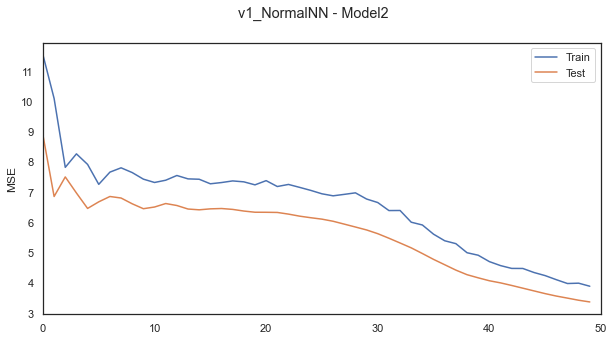

In [25]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 5)

loss_values2_backcalculated = [loss_v * len(modeling_dataset) for loss_v in loss_values2]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model2 - Gene Expression");

axs.plot(loss_values2_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_test2, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, NUM_EPOCHS, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values2_backcalculated):2.8f}
    mean : {np.mean(loss_values2_backcalculated):2.8f}
    max  : {np.max(loss_values2_backcalculated):2.8f}
    sd   : {np.std(loss_values2_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_test2):2.8f}
    mean : {np.mean(loss_values_test2):2.8f}
    max  : {np.max(loss_values_test2):2.8f}
    sd   : {np.std(loss_values_test2):2.8f}
""")

### Save or Load Model

In [26]:
torch.save(obj={
            'epoch': NUM_EPOCHS,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_func': loss_func,
            'loss_values_train': loss_values2_backcalculated,
            'loss_values_test': loss_values_test2,
            },
            f=PATH_TO_SAVE_MODELS_TO+'model2__gene_expr.pkl')

--- 

## Baseline Model using CNV Gistic

In [27]:
# Drug data.
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
drug_name_fps_v2 = pd.merge(left     = drug_name_fps, 
                            right    = cnv_gistic[['DRUG_ID', 'DRUG_NAME']], 
                            how      = 'left', 
                            left_on  = ['drug_name'], 
                            right_on = ['DRUG_NAME'])
drug_name_fps_v2.drop_duplicates(inplace=True)
drug_name_fps_v2.drop(['DRUG_NAME'], axis=1, inplace=True)                           
print(f"Drug Shape: {drug_name_fps_v2.shape}")
# drug_name_fps_v2.head(3)

# For each row of the FULL_DATASET get the corresponding Morgan Fingerprint for the specific drug.
FPS = pd.merge(left     = cnv_gistic['DRUG_ID'], 
               right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
               how      = 'left', 
               left_on  = ['DRUG_ID'], 
               right_on = ['DRUG_ID'])
print(f"Shape: {FPS.shape}")
FPS.head(5)  

Drug Shape: (428, 258)
Shape: (446521, 257)


,DRUG_ID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
from typing import List
import copy

class ModelDataset(Dataset): 
    def __init__(self, 
                 full_data: pd.DataFrame,
                 cell_cols: List[str],
                 drug_cols: List[str],
                 cell_identifier: str,
                 drug_identifier: str,
                 corresponding_fps: pd.DataFrame = FPS,
                 target_col: str='LN_IC50'): 
        # Drop all nans. 
        print(f"Initial shape before removing NaN's : {full_data.shape}")
        full_data = full_data.dropna()
        print(f"Shape after removing all NaN's      : {full_data.shape}")

        X = full_data[cell_cols + drug_cols]
        y = full_data[target_col]

        fps = pd.merge(left     = full_data['DRUG_ID'], 
                       right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                       how      = 'left', 
                       left_on  = ['DRUG_ID'], 
                       right_on = ['DRUG_ID'])

        X_cell = X[cell_cols]
        X_drug = copy.deepcopy(fps)

        print(f"X_cell.shape : {X_cell.shape}")
        print(f"X_drug.shape : {X_drug.shape}")

        # Contains only the gene columns and the respective feature value. Here GeneExpression.
        self.X = torch.tensor(X.loc[:, ~X.columns.isin([cell_identifier] + ['DRUG_NAME'])].values, dtype=torch.float32)
        self.X_cell = torch.tensor(X_cell.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        self.X_drug = torch.tensor(X_drug.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X_cell[idx], self.X_drug[idx], self.y[idx]

In [30]:
# --------------------------------------------------- #
# Delete all rows from the dataset for which there is #
# no fingerprint for the specific drug.               #
# --------------------------------------------------- #
SAVE, READ = False, True 

# Dataset for modeling which has fingerprints for each DRUG_ID.
if not READ:
    all_drugs_with_fps = np.unique(drug_name_fps_v2.DRUG_ID).tolist()
    modeling_dataset = cnv_gistic[cnv_gistic.DRUG_ID.isin(all_drugs_with_fps)]

    uniq_drugs_in__modeling_dataset = len(np.unique(modeling_dataset.DRUG_ID.values))
    uniq_drugs_with__fingerprints = len(np.unique(drug_name_fps_v2.DRUG_ID).tolist())

    assert uniq_drugs_in__modeling_dataset == uniq_drugs_with__fingerprints,\
        f"ERROR: Modeling dataset has {uniq_drugs_in__modeling_dataset} DRUG_ID's while there are only {uniq_drugs_with__fingerprints} DRUG_ID's with fingerprints."

    start = time.time()
    modeling_dataset_converted = convert_column_types(df              = modeling_dataset,
                                                      cols_to_convert = ALL_GENES,
                                                      conversion_type = 'float64')
    print(f"Elapsed time to convert the {len(ALL_GENES)} columns: {time.time() - start:2.2f} seconds.")
    if SAVE:
        modeling_dataset_converted.to_pickle(f'{PATH_TO_SAVE_DATA_TO}cnv_gistic_converted.pkl')
else:
    modeling_dataset_converted = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}cnv_gistic_converted.pkl')

# ---------------------------- #
# Create the modeling dataset. #
# ---------------------------- #
CELL_IDENTIFIER = 'CELL_LINE_NAME'
DRUG_IDENTIFIER = 'DRUG_ID'
TARGET_IDENTIFIER = 'LN_IC50'

model_dataset = ModelDataset(full_data       = modeling_dataset_converted,
                             cell_cols       = [CELL_IDENTIFIER] + list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values),
                             drug_cols       = [DRUG_IDENTIFIER, 'DRUG_NAME'],
                             cell_identifier = CELL_IDENTIFIER,
                             drug_identifier = DRUG_IDENTIFIER,
                             target_col      = TARGET_IDENTIFIER)

assert torch.isnan(model_dataset.X_drug).any() == False,\
    "ERROR: Some drugs in the dataset have no fingerprints."

Elapsed time to convert the 870 columns: 147.41 seconds.
Initial shape before removing NaN's : (370963, 952)
Shape after removing all NaN's      : (363949, 952)
X_cell.shape : (363949, 871)
X_drug.shape : (363949, 257)


In [32]:
# ---------------- # 
# Hyper-parameters #
# ---------------- #
input_size   = len(ALL_GENES)
hidden_size   = 100
num_classes   = 1
NUM_EPOCHS    = 50
batch_size    = 20_000
learning_rate = 0.001  

# ------------------------------- #
# Create train and test datasets. #
# ------------------------------- #
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(model_dataset))
test_size = len(model_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(model_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

print(f"""Shapes 
    Train : 
        X : {train_set.dataset.X.shape}
            X_cell : {train_set.dataset.X_cell.shape}
            X_drug : {train_set.dataset.X_drug.shape}
        y : {train_set.dataset.y.shape}
    Test  :
        X : {test_set.dataset.X.shape}
            X_cell : {test_set.dataset.X_cell.shape}
            X_drug : {test_set.dataset.X_drug.shape}            
        y : {test_set.dataset.y.shape}
""")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

count_train = sum(1 for X, X_cell, X_drug, y in train_loader)
count_test = sum(1 for X, X_cell, X_drug, y in test_loader)
print(f"""Batch counts:
    Train  : {count_train}
    Test   : {count_test}
""")                                         

Shapes 
    Train : 
        X : torch.Size([363949, 871])
            X_cell : torch.Size([363949, 870])
            X_drug : torch.Size([363949, 256])
        y : torch.Size([363949])
    Test  :
        X : torch.Size([363949, 871])
            X_cell : torch.Size([363949, 870])
            X_drug : torch.Size([363949, 256])            
        y : torch.Size([363949])

Batch counts:
    Train  : 15
    Test   : 4



### Running the Model

In [35]:
%load_ext autoreload
%autoreload 2
from v1_NormalNN            import Model2CnvGistic
from my_utils.model_helpers import train_and_test_model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model_cnv_gistic = Model2CnvGistic().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_cnv_gistic.parameters(), 
                             lr     = learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model_cnv_gistic, loss_values_cnv_gistic__train, loss_values_cnv_gistic__test = train_and_test_model(modeling_dataset = modeling_dataset_converted,
                                                                                                     model            = model_cnv_gistic,
                                                                                                     criterion        = loss_func,
                                                                                                     optimizer        = optimizer,
                                                                                                     num_epochs       = NUM_EPOCHS,
                                                                                                     device           = device,
                                                                                                     train_loader     = train_loader,
                                                                                                     test_loader      = test_loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


0it [00:03, ?it/s]


Epoch [1/50], Step [1/15], Loss: 11.5498
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 10.287898063659668


0it [00:02, ?it/s]


Epoch [2/50], Step [1/15], Loss: 11.3265
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 9.989877700805664


0it [00:02, ?it/s]


Epoch [3/50], Step [1/15], Loss: 10.9885
loss_values : 0.0000


4it [00:08,  2.05s/it]


MSE (test) : 9.505460739135742


0it [00:02, ?it/s]


Epoch [4/50], Step [1/15], Loss: 10.3739
loss_values : 0.0000


4it [00:16,  4.02s/it]


MSE (test) : 8.741612434387207


0it [00:02, ?it/s]


Epoch [5/50], Step [1/15], Loss: 9.5921
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 7.723415851593018


0it [00:02, ?it/s]


Epoch [6/50], Step [1/15], Loss: 8.5820
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 6.898993968963623


0it [00:03, ?it/s]


Epoch [7/50], Step [1/15], Loss: 7.6299
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 7.880240440368652


0it [00:02, ?it/s]


Epoch [8/50], Step [1/15], Loss: 8.6750
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 7.542111873626709


0it [00:02, ?it/s]


Epoch [9/50], Step [1/15], Loss: 8.2793
loss_values : 0.0000


4it [00:08,  2.04s/it]


MSE (test) : 6.912644386291504


0it [00:03, ?it/s]


Epoch [10/50], Step [1/15], Loss: 7.7550
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 6.769532203674316


0it [00:03, ?it/s]


Epoch [11/50], Step [1/15], Loss: 7.3295
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 6.892431259155273


0it [00:02, ?it/s]


Epoch [12/50], Step [1/15], Loss: 7.6179
loss_values : 0.0000


4it [00:08,  2.09s/it]


MSE (test) : 7.0124006271362305


0it [00:02, ?it/s]


Epoch [13/50], Step [1/15], Loss: 7.6715
loss_values : 0.0000


4it [00:08,  2.04s/it]


MSE (test) : 7.038949012756348


0it [00:02, ?it/s]


Epoch [14/50], Step [1/15], Loss: 7.6768
loss_values : 0.0000


4it [00:08,  2.08s/it]


MSE (test) : 6.9621124267578125


0it [00:03, ?it/s]


Epoch [15/50], Step [1/15], Loss: 7.6678
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 6.813090801239014


0it [00:02, ?it/s]


Epoch [16/50], Step [1/15], Loss: 7.5383
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 6.653331279754639


0it [00:02, ?it/s]


Epoch [17/50], Step [1/15], Loss: 7.4798
loss_values : 0.0000


4it [00:10,  2.71s/it]


MSE (test) : 6.568361759185791


0it [00:02, ?it/s]


Epoch [18/50], Step [1/15], Loss: 7.2231
loss_values : 0.0000


4it [00:08,  2.17s/it]


MSE (test) : 6.60094690322876


0it [00:02, ?it/s]


Epoch [19/50], Step [1/15], Loss: 7.2722
loss_values : 0.0000


4it [00:07,  1.94s/it]


MSE (test) : 6.650779724121094


0it [00:02, ?it/s]


Epoch [20/50], Step [1/15], Loss: 7.4063
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 6.584618091583252


0it [00:02, ?it/s]


Epoch [21/50], Step [1/15], Loss: 7.2551
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.451302528381348


0it [00:02, ?it/s]


Epoch [22/50], Step [1/15], Loss: 7.0439
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 6.3474836349487305


0it [00:02, ?it/s]


Epoch [23/50], Step [1/15], Loss: 7.0361
loss_values : 0.0000


4it [00:07,  2.00s/it]


MSE (test) : 6.297128200531006


0it [00:02, ?it/s]


Epoch [24/50], Step [1/15], Loss: 6.9855
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 6.27177619934082


0it [00:03, ?it/s]


Epoch [25/50], Step [1/15], Loss: 6.9315
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.230142593383789


0it [00:02, ?it/s]


Epoch [26/50], Step [1/15], Loss: 6.9161
loss_values : 0.0000


4it [00:08,  2.08s/it]


MSE (test) : 6.1539716720581055


0it [00:02, ?it/s]


Epoch [27/50], Step [1/15], Loss: 6.7411
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 6.051032066345215


0it [00:02, ?it/s]


Epoch [28/50], Step [1/15], Loss: 6.5857
loss_values : 0.0000


4it [00:08,  2.05s/it]


MSE (test) : 5.945850849151611


0it [00:03, ?it/s]


Epoch [29/50], Step [1/15], Loss: 6.4809
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 5.860336780548096


0it [00:02, ?it/s]


Epoch [30/50], Step [1/15], Loss: 6.4945
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 5.789314270019531


0it [00:03, ?it/s]


Epoch [31/50], Step [1/15], Loss: 6.3736
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 5.69881534576416


0it [00:02, ?it/s]


Epoch [32/50], Step [1/15], Loss: 6.4978
loss_values : 0.0000


4it [00:08,  2.00s/it]


MSE (test) : 5.5747504234313965


0it [00:02, ?it/s]


Epoch [33/50], Step [1/15], Loss: 6.0566
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 5.444767951965332


0it [00:03, ?it/s]


Epoch [34/50], Step [1/15], Loss: 5.9937
loss_values : 0.0000


4it [00:07,  2.00s/it]


MSE (test) : 5.3287353515625


0it [00:02, ?it/s]


Epoch [35/50], Step [1/15], Loss: 5.8459
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 5.219627380371094


0it [00:02, ?it/s]


Epoch [36/50], Step [1/15], Loss: 5.5900
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 5.0987067222595215


0it [00:02, ?it/s]


Epoch [37/50], Step [1/15], Loss: 5.6897
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 4.964186668395996


0it [00:02, ?it/s]


Epoch [38/50], Step [1/15], Loss: 5.4739
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 4.836513996124268


0it [00:02, ?it/s]


Epoch [39/50], Step [1/15], Loss: 5.3813
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 4.725646018981934


0it [00:02, ?it/s]


Epoch [40/50], Step [1/15], Loss: 5.1571
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 4.613051891326904


0it [00:02, ?it/s]


Epoch [41/50], Step [1/15], Loss: 5.1322
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 4.496540069580078


0it [00:02, ?it/s]


Epoch [42/50], Step [1/15], Loss: 4.9434
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 4.391961574554443


0it [00:03, ?it/s]


Epoch [43/50], Step [1/15], Loss: 4.8066
loss_values : 0.0000


4it [00:11,  2.77s/it]


MSE (test) : 4.293575763702393


0it [00:02, ?it/s]


Epoch [44/50], Step [1/15], Loss: 4.7487
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 4.191345691680908


0it [00:02, ?it/s]


Epoch [45/50], Step [1/15], Loss: 4.6716
loss_values : 0.0000


4it [00:08,  2.04s/it]


MSE (test) : 4.091801643371582


0it [00:02, ?it/s]


Epoch [46/50], Step [1/15], Loss: 4.5333
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 3.9993948936462402


0it [00:02, ?it/s]


Epoch [47/50], Step [1/15], Loss: 4.4324
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 3.9014976024627686


0it [00:02, ?it/s]


Epoch [48/50], Step [1/15], Loss: 4.3375
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 3.805574655532837


0it [00:02, ?it/s]


Epoch [49/50], Step [1/15], Loss: 4.2002
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 3.7178192138671875


0it [00:02, ?it/s]


Epoch [50/50], Step [1/15], Loss: 4.1051
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 3.633633613586426


### Performance Visualization


TRAIN
    min  : 4.10506153
    mean : 6.84152286
    max  : 11.54975319
    sd   : 1.78055143
TEST
    min  : 3.63363361
    mean : 6.06910229
    max  : 10.28789806
    sd   : 1.54344225



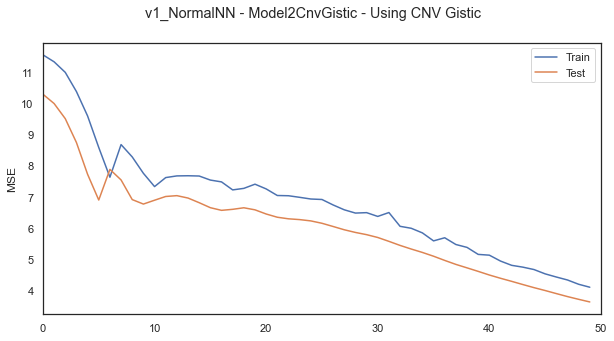

In [36]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 5)

loss_values_cnv_gistic__train_backcalculated = [loss_v * len(modeling_dataset_converted) for loss_v in loss_values_cnv_gistic__train]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model2CnvGistic - Using CNV Gistic");

axs.plot(loss_values_cnv_gistic__train_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_cnv_gistic__test, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, NUM_EPOCHS, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values_cnv_gistic__train_backcalculated):2.8f}
    mean : {np.mean(loss_values_cnv_gistic__train_backcalculated):2.8f}
    max  : {np.max(loss_values_cnv_gistic__train_backcalculated):2.8f}
    sd   : {np.std(loss_values_cnv_gistic__train_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_cnv_gistic__test):2.8f}
    mean : {np.mean(loss_values_cnv_gistic__test):2.8f}
    max  : {np.max(loss_values_cnv_gistic__test):2.8f}
    sd   : {np.std(loss_values_cnv_gistic__test):2.8f}
""")

### Save or Load Model

In [38]:
torch.save(obj={
            'epoch': NUM_EPOCHS,
            'model_state_dict': model_cnv_gistic.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_func': loss_func,
            'loss_values_train': loss_values_cnv_gistic__train_backcalculated,
            'loss_values_test': loss_values_cnv_gistic__test,
            },
            f=PATH_TO_SAVE_MODELS_TO+'Model2CnvGistic__cnv_gistic.pkl')

--- 

## Baseline Model using CNV Picnic

In [39]:
# Drug data.
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
drug_name_fps_v2 = pd.merge(left     = drug_name_fps, 
                            right    = cnv_picnic[['DRUG_ID', 'DRUG_NAME']], 
                            how      = 'left', 
                            left_on  = ['drug_name'], 
                            right_on = ['DRUG_NAME'])
drug_name_fps_v2.drop_duplicates(inplace=True)
drug_name_fps_v2.drop(['DRUG_NAME'], axis=1, inplace=True)                           
print(f"Drug Shape: {drug_name_fps_v2.shape}")
# drug_name_fps_v2.head(3)

# For each row of the FULL_DATASET get the corresponding Morgan Fingerprint for the specific drug.
FPS = pd.merge(left     = cnv_picnic['DRUG_ID'], 
               right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
               how      = 'left', 
               left_on  = ['DRUG_ID'], 
               right_on = ['DRUG_ID'])
print(f"Shape: {FPS.shape}")
FPS.head(5)  

Drug Shape: (428, 258)
Shape: (446521, 257)


,DRUG_ID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
from typing import List
import copy

class ModelDataset(Dataset): 
    def __init__(self, 
                 full_data: pd.DataFrame,
                 cell_cols: List[str],
                 drug_cols: List[str],
                 cell_identifier: str,
                 drug_identifier: str,
                 corresponding_fps: pd.DataFrame = FPS,
                 target_col: str='LN_IC50'): 
        # Drop all nans. 
        print(f"Initial shape before removing NaN's : {full_data.shape}")
        full_data = full_data.dropna()
        print(f"Shape after removing all NaN's      : {full_data.shape}")

        X = full_data[cell_cols + drug_cols]
        y = full_data[target_col]

        fps = pd.merge(left     = full_data['DRUG_ID'], 
                       right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                       how      = 'left', 
                       left_on  = ['DRUG_ID'], 
                       right_on = ['DRUG_ID'])

        X_cell = X[cell_cols]
        X_drug = copy.deepcopy(fps)

        print(f"X_cell.shape : {X_cell.shape}")
        print(f"X_drug.shape : {X_drug.shape}")

        # Contains only the gene columns and the respective feature value. Here GeneExpression.
        self.X = torch.tensor(X.loc[:, ~X.columns.isin([cell_identifier] + ['DRUG_NAME'])].values, dtype=torch.float32)
        self.X_cell = torch.tensor(X_cell.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        self.X_drug = torch.tensor(X_drug.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X_cell[idx], self.X_drug[idx], self.y[idx]

In [41]:
# --------------------------------------------------- #
# Delete all rows from the dataset for which there is #
# no fingerprint for the specific drug.               #
# --------------------------------------------------- #
SAVE, READ = True, False 

# Dataset for modeling which has fingerprints for each DRUG_ID.
if not READ:
    all_drugs_with_fps = np.unique(drug_name_fps_v2.DRUG_ID).tolist()
    modeling_dataset = cnv_picnic[cnv_picnic.DRUG_ID.isin(all_drugs_with_fps)]

    uniq_drugs_in__modeling_dataset = len(np.unique(modeling_dataset.DRUG_ID.values))
    uniq_drugs_with__fingerprints = len(np.unique(drug_name_fps_v2.DRUG_ID).tolist())

    assert uniq_drugs_in__modeling_dataset == uniq_drugs_with__fingerprints,\
        f"ERROR: Modeling dataset has {uniq_drugs_in__modeling_dataset} DRUG_ID's while there are only {uniq_drugs_with__fingerprints} DRUG_ID's with fingerprints."

    start = time.time()
    modeling_dataset_converted = convert_column_types(df              = modeling_dataset,
                                                      cols_to_convert = ALL_GENES,
                                                      conversion_type = 'float64')
    print(f"Elapsed time to convert the {len(ALL_GENES)} columns: {time.time() - start:2.2f} seconds.")
    if SAVE:
        modeling_dataset_converted.to_pickle(f'{PATH_TO_SAVE_DATA_TO}cnv_picnic_converted.pkl')
else:
    modeling_dataset_converted = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}cnv_picnic_converted.pkl')

# ---------------------------- #
# Create the modeling dataset. #
# ---------------------------- #
CELL_IDENTIFIER = 'CELL_LINE_NAME'
DRUG_IDENTIFIER = 'DRUG_ID'
TARGET_IDENTIFIER = 'LN_IC50'

model_dataset = ModelDataset(full_data       = modeling_dataset_converted,
                             cell_cols       = [CELL_IDENTIFIER] + list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values),
                             drug_cols       = [DRUG_IDENTIFIER, 'DRUG_NAME'],
                             cell_identifier = CELL_IDENTIFIER,
                             drug_identifier = DRUG_IDENTIFIER,
                             target_col      = TARGET_IDENTIFIER)

assert torch.isnan(model_dataset.X_drug).any() == False,\
    "ERROR: Some drugs in the dataset have no fingerprints."

Elapsed time to convert the 870 columns: 200.81 seconds.
Initial shape before removing NaN's : (370963, 980)
Shape after removing all NaN's      : (351889, 980)
X_cell.shape : (351889, 871)
X_drug.shape : (351889, 257)


In [42]:
# ---------------- # 
# Hyper-parameters #
# ---------------- #
input_size   = len(ALL_GENES)
hidden_size   = 100
num_classes   = 1
NUM_EPOCHS    = 50
batch_size    = 20_000
learning_rate = 0.001  

# ------------------------------- #
# Create train and test datasets. #
# ------------------------------- #
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(model_dataset))
test_size = len(model_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(model_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

print(f"""Shapes 
    Train : 
        X : {train_set.dataset.X.shape}
            X_cell : {train_set.dataset.X_cell.shape}
            X_drug : {train_set.dataset.X_drug.shape}
        y : {train_set.dataset.y.shape}
    Test  :
        X : {test_set.dataset.X.shape}
            X_cell : {test_set.dataset.X_cell.shape}
            X_drug : {test_set.dataset.X_drug.shape}            
        y : {test_set.dataset.y.shape}
""")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

count_train = sum(1 for X, X_cell, X_drug, y in train_loader)
count_test = sum(1 for X, X_cell, X_drug, y in test_loader)
print(f"""Batch counts:
    Train  : {count_train}
    Test   : {count_test}
""")                                         

Shapes 
    Train : 
        X : torch.Size([351889, 871])
            X_cell : torch.Size([351889, 870])
            X_drug : torch.Size([351889, 256])
        y : torch.Size([351889])
    Test  :
        X : torch.Size([351889, 871])
            X_cell : torch.Size([351889, 870])
            X_drug : torch.Size([351889, 256])            
        y : torch.Size([351889])

Batch counts:
    Train  : 15
    Test   : 4



### Running the Model

In [43]:
%load_ext autoreload
%autoreload
from v1_NormalNN            import Model2CnvGistic
from my_utils.model_helpers import train_and_test_model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model_cnv_picnic = Model2CnvGistic().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_cnv_picnic.parameters(), 
                             lr     = learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model_cnv_picnic, loss_values_cnv_picnic__train, loss_values_cnv_picnic__test = train_and_test_model(modeling_dataset = modeling_dataset_converted,
                                                                                                     model            = model_cnv_picnic,
                                                                                                     criterion        = loss_func,
                                                                                                     optimizer        = optimizer,
                                                                                                     num_epochs       = NUM_EPOCHS,
                                                                                                     device           = device,
                                                                                                     train_loader     = train_loader,
                                                                                                     test_loader      = test_loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


0it [00:03, ?it/s]


Epoch [1/50], Step [1/15], Loss: 11.5626
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 9.613130569458008


0it [00:03, ?it/s]


Epoch [2/50], Step [1/15], Loss: 10.8112
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 8.362184524536133


0it [00:02, ?it/s]


Epoch [3/50], Step [1/15], Loss: 9.5295
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 6.921557903289795


0it [00:02, ?it/s]


Epoch [4/50], Step [1/15], Loss: 7.7450
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 7.436706066131592


0it [00:03, ?it/s]


Epoch [5/50], Step [1/15], Loss: 8.4114
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 7.244007587432861


0it [00:03, ?it/s]


Epoch [6/50], Step [1/15], Loss: 8.2670
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.695679664611816


0it [00:06, ?it/s]


Epoch [7/50], Step [1/15], Loss: 7.4813
loss_values : 0.0000


4it [00:09,  2.47s/it]


MSE (test) : 6.7349138259887695


0it [00:02, ?it/s]


Epoch [8/50], Step [1/15], Loss: 7.5576
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.924720287322998


0it [00:02, ?it/s]


Epoch [9/50], Step [1/15], Loss: 7.7986
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 6.9788384437561035


0it [00:03, ?it/s]


Epoch [10/50], Step [1/15], Loss: 7.9066
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 6.87841272354126


0it [00:02, ?it/s]


Epoch [11/50], Step [1/15], Loss: 7.8412
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.711673259735107


0it [00:02, ?it/s]


Epoch [12/50], Step [1/15], Loss: 7.4830
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 6.623083591461182


0it [00:02, ?it/s]


Epoch [13/50], Step [1/15], Loss: 7.2848
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 6.7190046310424805


0it [00:02, ?it/s]


Epoch [14/50], Step [1/15], Loss: 7.4862
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 6.809132099151611


0it [00:03, ?it/s]


Epoch [15/50], Step [1/15], Loss: 7.7754
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 6.718391418457031


0it [00:02, ?it/s]


Epoch [16/50], Step [1/15], Loss: 7.5997
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 6.598844528198242


0it [00:02, ?it/s]


Epoch [17/50], Step [1/15], Loss: 7.5831
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.567220211029053


0it [00:03, ?it/s]


Epoch [18/50], Step [1/15], Loss: 7.5027
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 6.593533039093018


0it [00:03, ?it/s]


Epoch [19/50], Step [1/15], Loss: 7.4185
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 6.601471900939941


0it [00:02, ?it/s]


Epoch [20/50], Step [1/15], Loss: 7.5157
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 6.5555219650268555


0it [00:02, ?it/s]


Epoch [21/50], Step [1/15], Loss: 7.3611
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.476235389709473


0it [00:02, ?it/s]


Epoch [22/50], Step [1/15], Loss: 7.3420
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 6.4111552238464355


0it [00:03, ?it/s]


Epoch [23/50], Step [1/15], Loss: 7.3864
loss_values : 0.0000


4it [00:08,  2.05s/it]


MSE (test) : 6.382062911987305


0it [00:02, ?it/s]


Epoch [24/50], Step [1/15], Loss: 7.2165
loss_values : 0.0000


4it [00:07,  2.00s/it]


MSE (test) : 6.348931789398193


0it [00:03, ?it/s]


Epoch [25/50], Step [1/15], Loss: 7.2175
loss_values : 0.0000


4it [00:08,  2.00s/it]


MSE (test) : 6.271965503692627


0it [00:03, ?it/s]


Epoch [26/50], Step [1/15], Loss: 7.1466
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 6.160959720611572


0it [00:02, ?it/s]


Epoch [27/50], Step [1/15], Loss: 6.9765
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.048351764678955


0it [00:02, ?it/s]


Epoch [28/50], Step [1/15], Loss: 6.8287
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 5.943234443664551


0it [00:02, ?it/s]


Epoch [29/50], Step [1/15], Loss: 6.7254
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 5.820322513580322


0it [00:02, ?it/s]


Epoch [30/50], Step [1/15], Loss: 6.6323
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 5.669946670532227


0it [00:02, ?it/s]


Epoch [31/50], Step [1/15], Loss: 6.4258
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 5.515863418579102


0it [00:02, ?it/s]


Epoch [32/50], Step [1/15], Loss: 6.3035
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 5.372585773468018


0it [00:02, ?it/s]


Epoch [33/50], Step [1/15], Loss: 5.9818
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 5.210654258728027


0it [00:03, ?it/s]


Epoch [34/50], Step [1/15], Loss: 5.8707
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 5.026603698730469


0it [00:02, ?it/s]


Epoch [35/50], Step [1/15], Loss: 5.6260
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 4.865520477294922


0it [00:02, ?it/s]


Epoch [36/50], Step [1/15], Loss: 5.5135
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 4.721439838409424


0it [00:02, ?it/s]


Epoch [37/50], Step [1/15], Loss: 5.3810
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 4.572690010070801


0it [00:02, ?it/s]


Epoch [38/50], Step [1/15], Loss: 5.0671
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 4.44225549697876


0it [00:02, ?it/s]


Epoch [39/50], Step [1/15], Loss: 4.9888
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 4.319393157958984


0it [00:02, ?it/s]


Epoch [40/50], Step [1/15], Loss: 4.8293
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 4.187253475189209


0it [00:02, ?it/s]


Epoch [41/50], Step [1/15], Loss: 4.7507
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 4.075752258300781


0it [00:02, ?it/s]


Epoch [42/50], Step [1/15], Loss: 4.5821
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 3.9591760635375977


0it [00:02, ?it/s]


Epoch [43/50], Step [1/15], Loss: 4.3682
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 3.848170757293701


0it [00:02, ?it/s]


Epoch [44/50], Step [1/15], Loss: 4.3044
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 3.7534000873565674


0it [00:02, ?it/s]


Epoch [45/50], Step [1/15], Loss: 4.2840
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 3.6535110473632812


0it [00:02, ?it/s]


Epoch [46/50], Step [1/15], Loss: 4.1410
loss_values : 0.0000


4it [00:08,  2.19s/it]


MSE (test) : 3.570467233657837


0it [00:02, ?it/s]


Epoch [47/50], Step [1/15], Loss: 3.9447
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 3.4874887466430664


0it [00:02, ?it/s]


Epoch [48/50], Step [1/15], Loss: 3.9495
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 3.4205667972564697


0it [00:03, ?it/s]


Epoch [49/50], Step [1/15], Loss: 3.8227
loss_values : 0.0000


4it [00:08,  2.12s/it]


MSE (test) : 3.3600473403930664


0it [00:03, ?it/s]


Epoch [50/50], Step [1/15], Loss: 3.7921
loss_values : 0.0000


4it [00:08,  2.12s/it]


MSE (test) : 3.296379804611206


### Performance Visualization


TRAIN
    min  : 3.79211283
    mean : 6.62641574
    max  : 11.56258011
    sd   : 1.78055143
TEST
    min  : 3.29637980
    mean : 5.72960806
    max  : 9.61313057
    sd   : 1.41519082



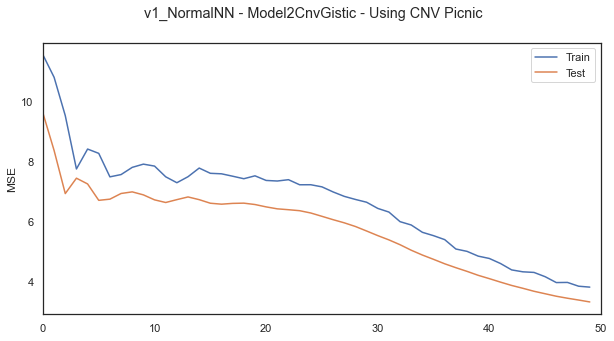

In [44]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 5)

loss_values_cnv_picnic__train_backcalculated = [loss_v * len(modeling_dataset_converted) for loss_v in loss_values_cnv_picnic__train]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model2CnvGistic - Using CNV Picnic");

axs.plot(loss_values_cnv_picnic__train_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_cnv_picnic__test, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, NUM_EPOCHS, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values_cnv_picnic__train_backcalculated):2.8f}
    mean : {np.mean(loss_values_cnv_picnic__train_backcalculated):2.8f}
    max  : {np.max(loss_values_cnv_picnic__train_backcalculated):2.8f}
    sd   : {np.std(loss_values_cnv_gistic__train_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_cnv_picnic__test):2.8f}
    mean : {np.mean(loss_values_cnv_picnic__test):2.8f}
    max  : {np.max(loss_values_cnv_picnic__test):2.8f}
    sd   : {np.std(loss_values_cnv_picnic__test):2.8f}
""")

### Save or Load Model

In [45]:
torch.save(obj={
            'epoch': NUM_EPOCHS,
            'model_state_dict': model_cnv_picnic.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_func': loss_func,
            'loss_values_train': loss_values_cnv_picnic__train_backcalculated,
            'loss_values_test': loss_values_cnv_picnic__test,
            },
            f=PATH_TO_SAVE_MODELS_TO+'Model2CnvGistic__cnv_picnic.pkl')

---

## Comparison

In [55]:
train_loss_values = {
    "gene_expr": loss_values2_backcalculated,
    "cnv_gistic": loss_values_cnv_gistic__train_backcalculated,
    "cnv_picnic": loss_values_cnv_picnic__train_backcalculated,
}

test_loss_values = {
    "gene_expr": loss_values_test2,
    "cnv_gistic": loss_values_cnv_gistic__test,
    "cnv_picnic": loss_values_cnv_picnic__test,
}

df_train = pd.DataFrame(train_loss_values).stack().reset_index().sort_values(['level_1'])
df_train['dataset'] = 'train'
df_train.drop(['level_0'], inplace=True, axis=1)
df_train.rename(columns={0: 'loss_value', 'level_1': 'feature'}, inplace=True)

df_test = pd.DataFrame(test_loss_values).stack().reset_index().sort_values(['level_1'])
df_test['dataset'] = 'test'
df_test.drop(['level_0'], inplace=True, axis=1)
df_test.rename(columns={0: 'loss_value', 'level_1': 'feature'}, inplace=True)

df_total = pd.concat([df_train, df_test])
df_total.head(5)

,feature,loss_value,dataset
37,cnv_gistic,7.671544,train
115,cnv_gistic,5.381312,train
34,cnv_gistic,7.617856,train
112,cnv_gistic,5.473936,train
73,cnv_gistic,6.931458,train


<AxesSubplot:xlabel='dataset', ylabel='loss_value'>

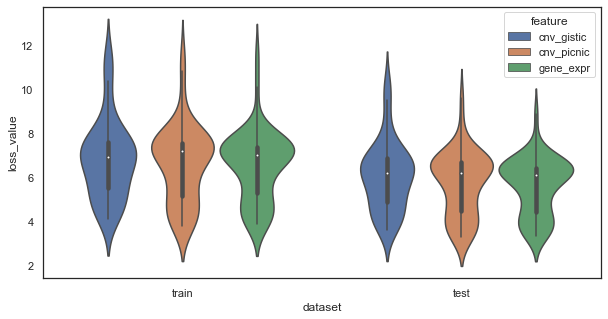

In [57]:
df_total['loss_value'] = df_total['loss_value'].astype('float')

sns.violinplot(data=df_total, x='dataset', y='loss_value', hue='feature')

### t-Test on the Significance of the Difference of the Means

In [81]:
from scipy import stats
from tabulate import tabulate

ALPHA = .05

losses_gene_expr = copy.deepcopy(loss_values_test2)
losses_cnv_gistic = copy.deepcopy(loss_values_cnv_gistic__test)
losses_cnv_picnic = copy.deepcopy(loss_values_cnv_picnic__test)

mu_expr, mu_cnvg, mu_cnvp = np.mean(losses_gene_expr), np.mean(losses_cnv_gistic), np.mean(losses_cnv_picnic)
sd2_expr, sd2_cnvg, sd2_cnvp = np.var(losses_gene_expr), np.var(losses_cnv_gistic), np.var(losses_cnv_picnic)

# Test all different permutations.
_, pvalue_expr_vs_gistic = stats.ttest_ind(losses_gene_expr, losses_cnv_gistic)
_, pvalue_expr_vs_picnic = stats.ttest_ind(losses_gene_expr, losses_cnv_picnic)
_, pvalue_gistic_vs_picnic = stats.ttest_ind(losses_cnv_gistic, losses_cnv_picnic)

def get_answer_of_ttest(pvalue, alpha=ALPHA):
    return 'Different' if pvalue < alpha else 'Identical'

print(tabulate(
    [
        ['Gene Expr', 'CNV Gistic', sd2_expr, sd2_cnvg, mu_cnvg, mu_expr, 
          get_answer_of_ttest(pvalue_expr_vs_gistic), pvalue_expr_vs_gistic],
        ['Gene Expr', 'CNV Picnic', sd2_expr, sd2_cnvp, mu_expr, mu_cnvp, 
          get_answer_of_ttest(pvalue_expr_vs_picnic), pvalue_expr_vs_picnic],          
        ['CNV Gistic', 'CNV Picnic', sd2_cnvg, sd2_cnvp, mu_cnvg, mu_cnvp, 
          get_answer_of_ttest(pvalue_gistic_vs_picnic), pvalue_gistic_vs_picnic],  
    ], headers=['Feature1', 'Feature2', 'var1', 'var2', 'mean1', 'mean2', f'<alpha={ALPHA}', 'p-value']      
))

Feature1    Feature2       var1     var2    mean1    mean2  <alpha=0.05      p-value
----------  ----------  -------  -------  -------  -------  -------------  ---------
Gene Expr   CNV Gistic  1.57732  2.38221  6.0691   5.62052  Identical       0.117777
Gene Expr   CNV Picnic  1.57732  2.00276  5.62052  5.72961  Identical       0.687397
CNV Gistic  CNV Picnic  2.38221  2.00276  6.0691   5.72961  Identical       0.259197


__Conclusions__: 
- Even though the t-tests all state that the means are not significantly different from one another, the assumption of a t-test, which is that the variances of both groups are equal, is not met.
- Thus, we can't trust the result.

---

## Todos

- [x] t-test on the means of the loss values of different groups
- [ ] normalize ic50 values by calculating the mean per drug group
- [ ] Check issue with different feature performance
- [ ] Different loss functions
- [ ] Build net for mutations data
- [ ] Run GNN with gene expr, cnv gistic and cnv picnic
- [ ] Regr and random forest 